In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import mord as m
import seaborn as sns
import numpy as np
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from sklearn.utils.class_weight import compute_class_weight

In [28]:
df = pd.read_csv("clean_data/movies.csv")

features = ["popularity", "revenue", "budget", "runtime"]
df = df.fillna(0)
df = df[features + ["vote_average"]]
df["label"] = df["vote_average"].apply(np.floor).astype(int)
# print majority class and percentage of that class
majority_class = df["label"].mode()[0]
majority_percentage = df["label"].value_counts(normalize=True).max()
print(f"Majority class: {majority_class}, Percentage: {majority_percentage:.2f}")

Majority class: 6, Percentage: 0.42


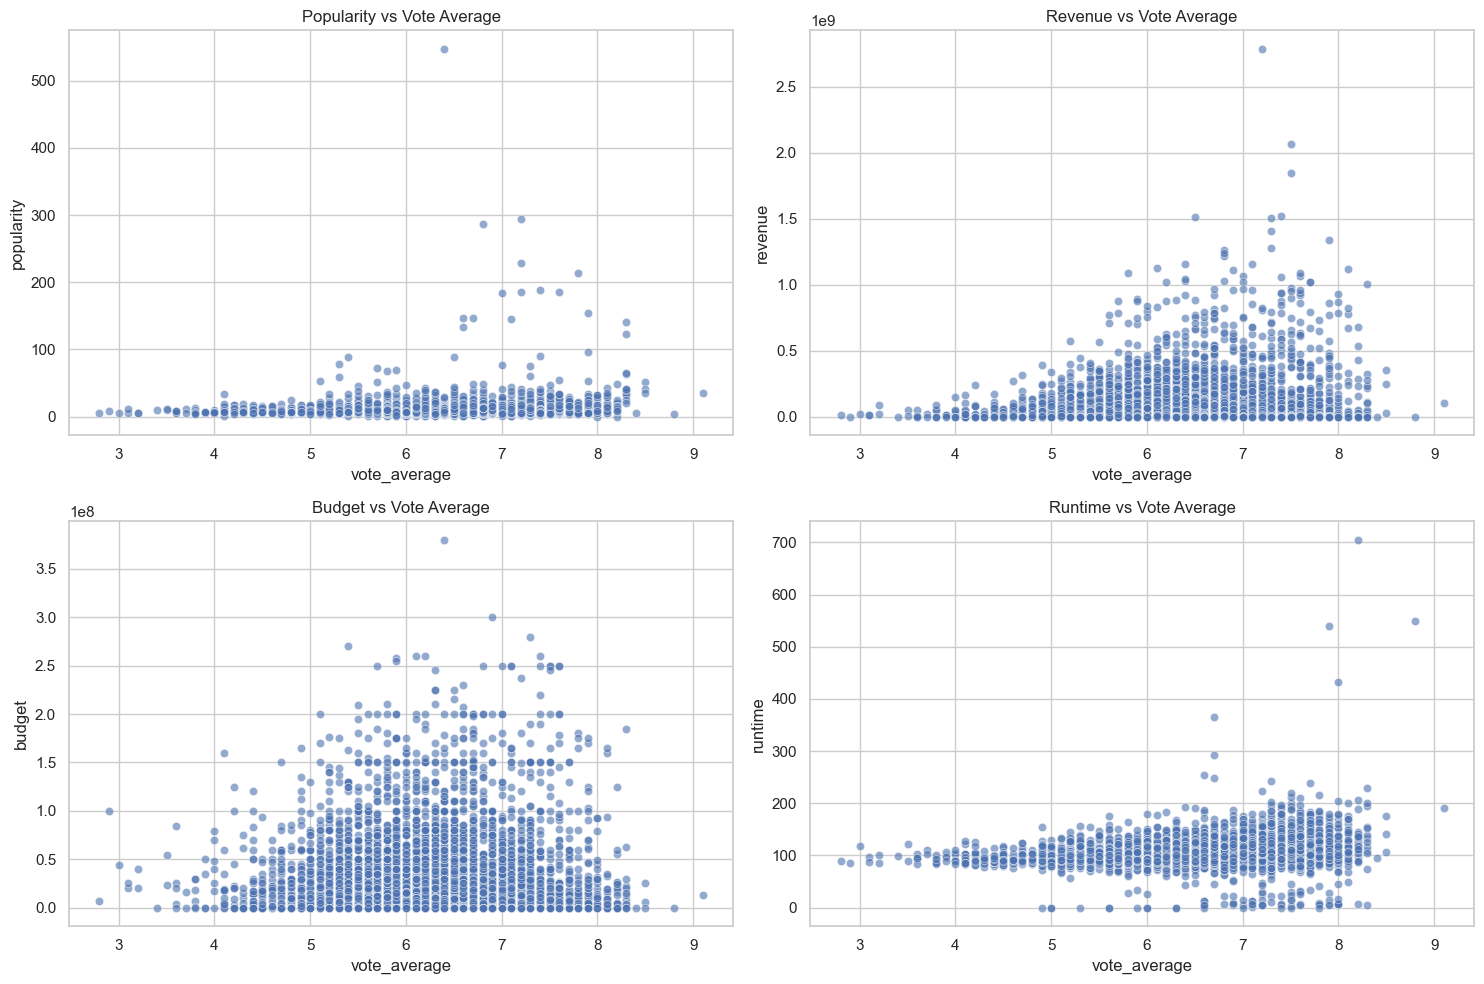

In [25]:
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot for popularity vs vote_average
sns.scatterplot(ax=axes[0, 0], x="vote_average", y="popularity", data=df, alpha=0.6)
axes[0, 0].set_title("Popularity vs Vote Average")

# Scatter plot for revenue vs vote_average
sns.scatterplot(ax=axes[0, 1], x="vote_average", y="revenue", data=df, alpha=0.6)
axes[0, 1].set_title("Revenue vs Vote Average")

# Scatter plot for budget vs vote_average
sns.scatterplot(ax=axes[1, 0], x="vote_average", y="budget", data=df, alpha=0.6)
axes[1, 0].set_title("Budget vs Vote Average")

# Scatter plot for runtime vs vote_average
sns.scatterplot(ax=axes[1, 1], x="vote_average", y="runtime", data=df, alpha=0.6)
axes[1, 1].set_title("Runtime vs Vote Average")

# Adjust layout
plt.tight_layout()
plt.show()

In [29]:
df.drop(["vote_average"], axis=1, inplace=True)

def prep_data(df):
    y = torch.tensor(df["label"].values)
    X = df.drop(["label"], axis = 1)
    X = torch.tensor(X.values)

    return X, y

X, y = prep_data(df)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_remap = y_train - 2
y_val_remap = y_val - 2
train_dataset = torch.utils.data.TensorDataset(X_train.float(), y_train_remap)
val_dataset = torch.utils.data.TensorDataset(X_val.float(), y_val_remap)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/var/folders/sn/hvdpnw3n7l35_lcfs2ppcb_80000gn/T/ipykernel_74163/1707297592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_remap.numpy(), palette="viridis")


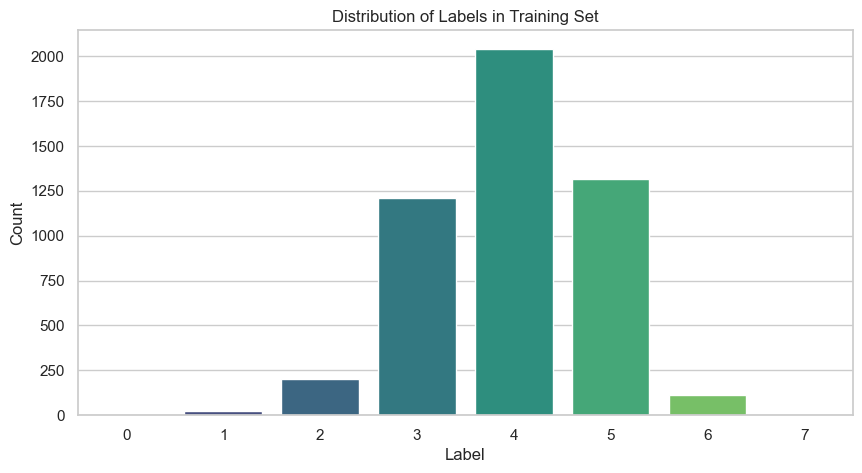

In [36]:
# plot the distribution of the labels
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_remap.numpy(), palette="viridis")
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
max_len = 512

def pad(l, max_len):
    if len(l) <= max_len:
        to_add = max_len - len(l)
        return l + [0]*to_add
    else:
        return l[:max_len]

def preprocess(df, tokenizer, max_len):
    X = tokenizer(list(df["lyrics"]))["input_ids"]
    X = [pad(t, max_len) for t in X]
    y = list(df["genre_numeric"])
    return X, y

class TextDataFromDF(Dataset):
    def __init__(self, df):
        self.X, self.y = preprocess(df, tokenizer, max_len)

    def __getitem__(self, ix):
        return self.X[ix], self.y[ix]

    def __len__(self):
        return len(self.y)
    
train_lyrics = TextDataFromDF(train_df)
val_lyrics   = TextDataFromDF(val_df)

In [ ]:
def collate(data):
    # lyrics = torch.tensor([d[0] for d in data])
    features = torch.tensor([d[2] for d in data])
    y = torch.tensor([d[1] for d in data])
    return features, y 

# train_features = train_df[engineered_features].values.tolist()
# val_features = val_df[engineered_features].values.tolist()
# train_data = [(train_lyrics[i][0], train_lyrics[i][1], train_features[i]) for i in range(len(train_lyrics))]
# val_data = [(val_lyrics[i][0], val_lyrics[i][1], val_features[i]) for i in range(len(val_lyrics))]

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn = collate)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, collate_fn = collate)

In [46]:
# optimizer = torch.optim.Adam(lyrics_model.parameters(), lr=.001)
# loss_fn = torch.nn.CrossEntropyLoss()

def train(dataloader, model):
    epoch_start_time = time.time()
    total_acc, total_count = 0, 0
    
    for X, y in dataloader:
        optimizer.zero_grad()
        predicted_label = model(X)
        loss = loss_fn(predicted_label, y)
        loss.backward()
        optimizer.step()
                
        total_acc   += (predicted_label.argmax(1) == y).sum().item()
        total_count += y.size(0)

    print(f'| epoch {epoch:3d} | train accuracy {total_acc/total_count:8.3f} | time: {time.time() - epoch_start_time:5.2f}s')

def accuracy(dataloader, model):

    total_acc, total_count = 0, 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for X, y in dataloader:
            predicted_label = model(X)
            total_acc += (predicted_label.argmax(1) == y).sum().item()
            total_count += y.size(0)
            predictions.extend(predicted_label.argmax(1).tolist())
            actuals.extend(y.tolist())
    return predictions, actuals, total_acc/total_count

# EPOCHS = 20
# for epoch in range(1, EPOCHS + 1):
#     train(train_loader, lyrics_model)

# print(f'validation accuracy: {accuracy(val_loader, lyrics_model)}')

In [47]:
classes = np.unique(y_train_remap.numpy())  # Now values from 0 to 7
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_remap.numpy())
weights = torch.tensor(weights, dtype=torch.float)


In [53]:
class FeaturesModel(nn.Module):
    def __init__(self, num_features, num_class):
        super().__init__()
        self.pipeline = nn.Sequential(
            nn.Linear(num_features, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(8, num_class),
        )

    def forward(self, features):
        return self.pipeline(features)

num_features = len(features)
features_model = FeaturesModel(num_features, len(classes))

optimizer = torch.optim.Adam(features_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    train(train_loader, features_model)

preds, actuals, val_acc = accuracy(val_loader, features_model)
print(f'Validation accuracy: {val_acc:.3f}')
print(preds)
print(actuals)

| epoch   1 | train accuracy    0.116 | time:  0.14s
| epoch   2 | train accuracy    0.296 | time:  0.10s
| epoch   3 | train accuracy    0.343 | time:  0.10s
| epoch   4 | train accuracy    0.359 | time:  0.10s
| epoch   5 | train accuracy    0.379 | time:  0.10s
| epoch   6 | train accuracy    0.390 | time:  0.09s
| epoch   7 | train accuracy    0.392 | time:  0.10s
| epoch   8 | train accuracy    0.397 | time:  0.09s
| epoch   9 | train accuracy    0.403 | time:  0.10s
| epoch  10 | train accuracy    0.399 | time:  0.10s
| epoch  11 | train accuracy    0.407 | time:  0.10s
| epoch  12 | train accuracy    0.410 | time:  0.09s
| epoch  13 | train accuracy    0.405 | time:  0.10s
| epoch  14 | train accuracy    0.407 | time:  0.10s
| epoch  15 | train accuracy    0.410 | time:  0.09s
| epoch  16 | train accuracy    0.409 | time:  0.09s
| epoch  17 | train accuracy    0.407 | time:  0.10s
| epoch  18 | train accuracy    0.411 | time:  0.13s
| epoch  19 | train accuracy    0.340 | time: 

In [41]:
scores = model(X_train.float())  # Ensure X_train is of type float
print(scores)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)


I did some very basic setup for what will become a deep learning model to analyze the movie data. I started with a simple linear model so that I have some of the structure in place for the future. I also improved my data prep process to involve torch tensors.